In [9]:
from qmratool.models import *
import pymc3 as pm
import plotly.express as px

In [20]:
y = pm.Normal.dist(mu=10, sigma=5)

In [21]:
fig = px.histogram(x = y.random(size=10000))
fig.show()

In [14]:
with pm.Model():

    x = pm.Normal('x', mu=0, sigma=1)

In [27]:
x.random(size=100)

array([-0.55035623, -0.82805017, -0.65664057,  1.16332055,  0.96138609,
        0.78759733,  1.73584501,  1.06948805, -0.47603688,  0.46407092,
       -1.05992802, -0.32387723, -0.62764979, -0.8365678 ,  0.81408342,
        1.97094823, -0.95936763,  0.01241038,  2.19453505,  2.02374899,
       -0.65127637, -0.21596757, -1.2780861 , -0.45350951,  1.68988557,
       -0.47941615,  0.51803201, -1.11791766, -0.15897484, -0.48903935,
        0.14607038, -0.73743119, -0.5274102 ,  0.8780214 , -0.41482384,
       -0.09597672, -0.39973942, -1.27804302,  0.03516018, -0.81782816,
        0.94728012, -0.56365141,  0.84574037,  1.50780204, -0.05809748,
        1.97983645, -1.54461184, -1.41605933, -0.93643087, -0.02873967,
       -0.68082601,  1.26765093, -1.64787501, -0.59027829,  0.97059868,
       -2.17538174, -1.25002173, -0.5380113 ,  0.00288302,  0.44630531,
       -1.19810142,  0.40971204,  0.38059312,  0.53543108,  0.11919577,
       -0.5527198 ,  1.34701618,  1.3691083 ,  0.20542267, -1.31

In [9]:
def calculate_risk(request, ra_id):
    ra = RiskAssessment.objects.get(id = ra_id)
    
    # Selecting inflow concentration based in source water type
    df_inflow = read_frame(Inflow.objects.filter(water_source=ra.source).values("min", "max", "pathogen__pathogen", "water_source__water_source_name"))
    
    # Querying dose response parameters based on pathogen inflow
    dr_models = read_frame(DoseResponse.objects.filter(pathogen__in=Pathogen.objects.filter(pathogen__in=df_inflow["pathogen__pathogen"])))
    
    # Querying for Logremoval based on selected treatments
    df_treatment=read_frame(LogRemoval.objects.filter(treatment__in=ra.treatment.all()).values("min", "max", "treatment__name", "pathogen_group__pathogen_group"))
    
    #Querying for exposure scenario
    #exposure =read_frame(ra.exposure.all().values("events_per_year", "volume_per_event"))

    # Summarizing treatment to treatment max and treatment min
    df_treatment_summary=df_treatment.groupby(["pathogen_group__pathogen_group"]).sum().reset_index()
    
        # annual risk function
    def annual_risk(nexposure, event_probs):
        return 1-np.prod(1-np.random.choice(event_probs, nexposure, True))
    #df_inflow = df_inflow["pathogen__pathogen"].isin(["Rotavirus", "Cryptosporidium parvum", "Campylobacter jejuni"])
    
    results = pd.DataFrame()
    for pathogen in ["Rotavirus", "Cryptosporidium parvum", "Campylobacter jejuni"]:#df_inflow["pathogen__pathogen"]:
        d = df_inflow.loc[df_inflow["pathogen__pathogen"] == pathogen]
        dr = dr_models.loc[dr_models["pathogen"]==pathogen]
        #result.append(pathogen)

        if pathogen == "Rotavirus":
            selector = "Viruses"
        elif pathogen == "Cryptosporidium parvum":
            selector = "Protozoa"
        else:
            selector = "Bacteria"
        #result.append(selector)

        df_treat = df_treatment_summary[df_treatment_summary["pathogen_group__pathogen_group"]==selector]
                                    
                                                         

        risk_df = pd.DataFrame({"inflow": np.random.normal(loc=(np.log10(float(d["min"])+10**(-8))+np.log10(float(d["max"]) ))/2, 
                                                            scale = (np.log10(float(d["max"]))-np.log10(float(d["min"])+10**(-8) ))/4,  
                                                            size = 1000),
                                "LRV": np.random.uniform(low= df_treat["min"], 
                                                         high= df_treat["max"], 
                                                         size= 1000) })
        risk_df["outflow"]=risk_df["inflow"] - risk_df["LRV"]
        risk_df["dose"] = (10**risk_df["outflow"])*float(ra.exposure.volume_per_event)
       
        if selector != "Protozoa":
            risk_df["probs"] = 1 - (1 + (risk_df["dose"]) * (2 ** (1/float(dr.alpha)) - 1)/float(dr.n50)) ** -float(dr.alpha)
        else:
            risk_df["probs"] = 1 - np.exp(-float(dr.k)*(risk_df["dose"]))
        
        results[pathogen] = [annual_risk(int(ra.exposure.events_per_year), risk_df["probs"] ) for _ in range(1000)]

    results_long = pd.melt(results)
    results_long["log probability"] = np.log10(results_long["value"])
    fig = px.box(results_long, x="variable", y="log probability", 
                                points="all",  
                                title="Risk assessment as probability of infection per year",
                                color_discrete_sequence=["#007c9f", "#007c9f", "#007c9f"])
    
    fig.update_layout(shapes=[
    dict(
      type= 'line',
      y0= np.log10(0.03), y1=np.log10(0.03),
      x0 =-.5, x1=2.5,
      line=dict(
        color="MediumPurple",
        width=4,
        dash="dot") 
    )
    ])
    
    risk_plot = plot(fig, output_type = "div")


     # reshaping dataframe for plotting
    df_inflow2 =pd.melt(df_inflow, ("pathogen__pathogen", "water_source__water_source_name"))
    df_inflow2 = df_inflow2[df_inflow2.pathogen__pathogen.isin(["Rotavirus", "Cryptosporidium parvum", "Campylobacter jejuni"])]
    fig2 = px.bar(df_inflow2, x="variable", y = "value", log_y=True,
    facet_col="pathogen__pathogen", barmode="group", 
    color_discrete_sequence=["#007c9f", "rgb(0, 86, 100)", "grey", "red3", "steelblue"],
    
    title="Inflow concentration")
    plot_div2 = plot(fig2, output_type = "div")

    # reshaping     
    df = pd.melt(df_treatment, ("treatment__name", "pathogen_group__pathogen_group"))
    fig = px.bar(df, x="variable", y = "value", 
    color="treatment__name", facet_col="pathogen_group__pathogen_group",
    color_discrete_sequence=["#007c9f", "rgb(0, 86, 100)", "grey"],
    title="Log-removal of selected treatment train")
    fig.update_layout(legend=dict(
                     orientation="h",
                     yanchor="bottom",
                     y=1.1,
                     xanchor="right",
                    x=1))
    plot_div = plot(fig, output_type = "div")

In [25]:
import numpy as np

In [41]:
X = 10

In [42]:
Y=10

In [44]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

In [45]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [46]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + np.random.randn(size) * sigma

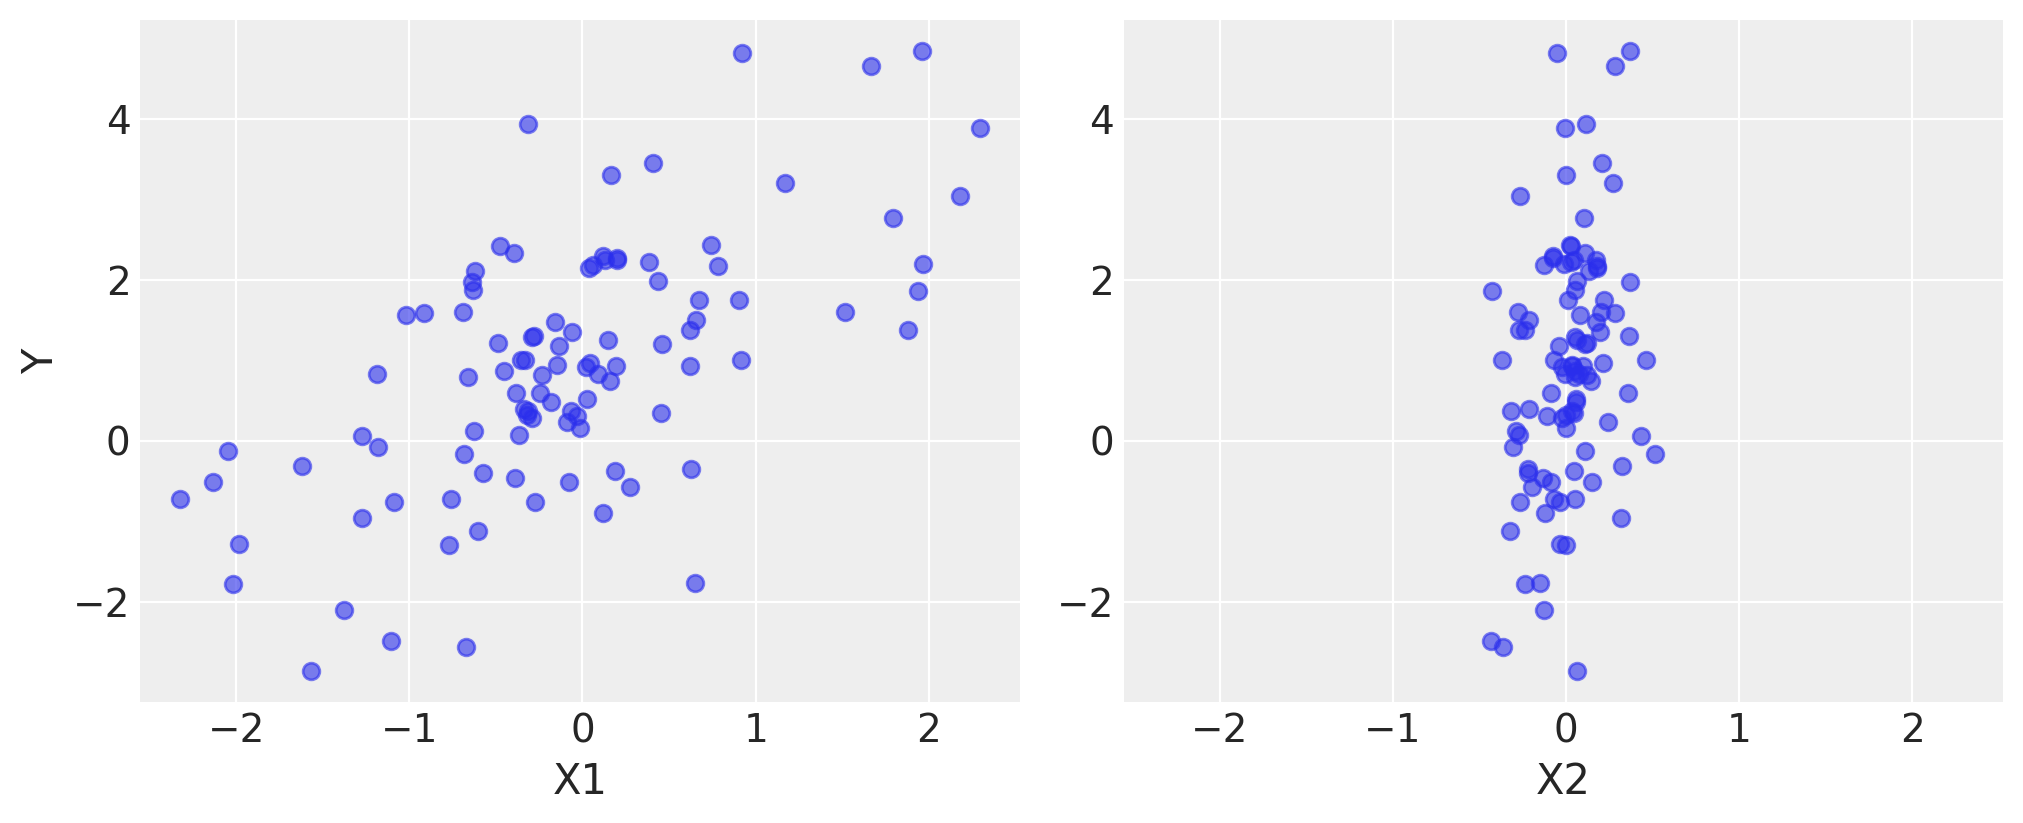

In [47]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

In [49]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

In [52]:
map_estimate = pm.find_MAP(model=basic_model)
map_estimate

{'alpha': array(0.95724679),
 'beta': array([1.10071814, 2.9511438 ]),
 'sigma_log__': array(0.03540151),
 'sigma': array(1.0360356)}

In [53]:
map_estimate = pm.find_MAP(model=basic_model, method="powell")
map_estimate



{'alpha': array(0.95835519),
 'beta': array([1.1017629 , 2.95394057]),
 'sigma_log__': array(0.03638187),
 'sigma': array(1.03705179)}

In [55]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(5000, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 7 seconds.


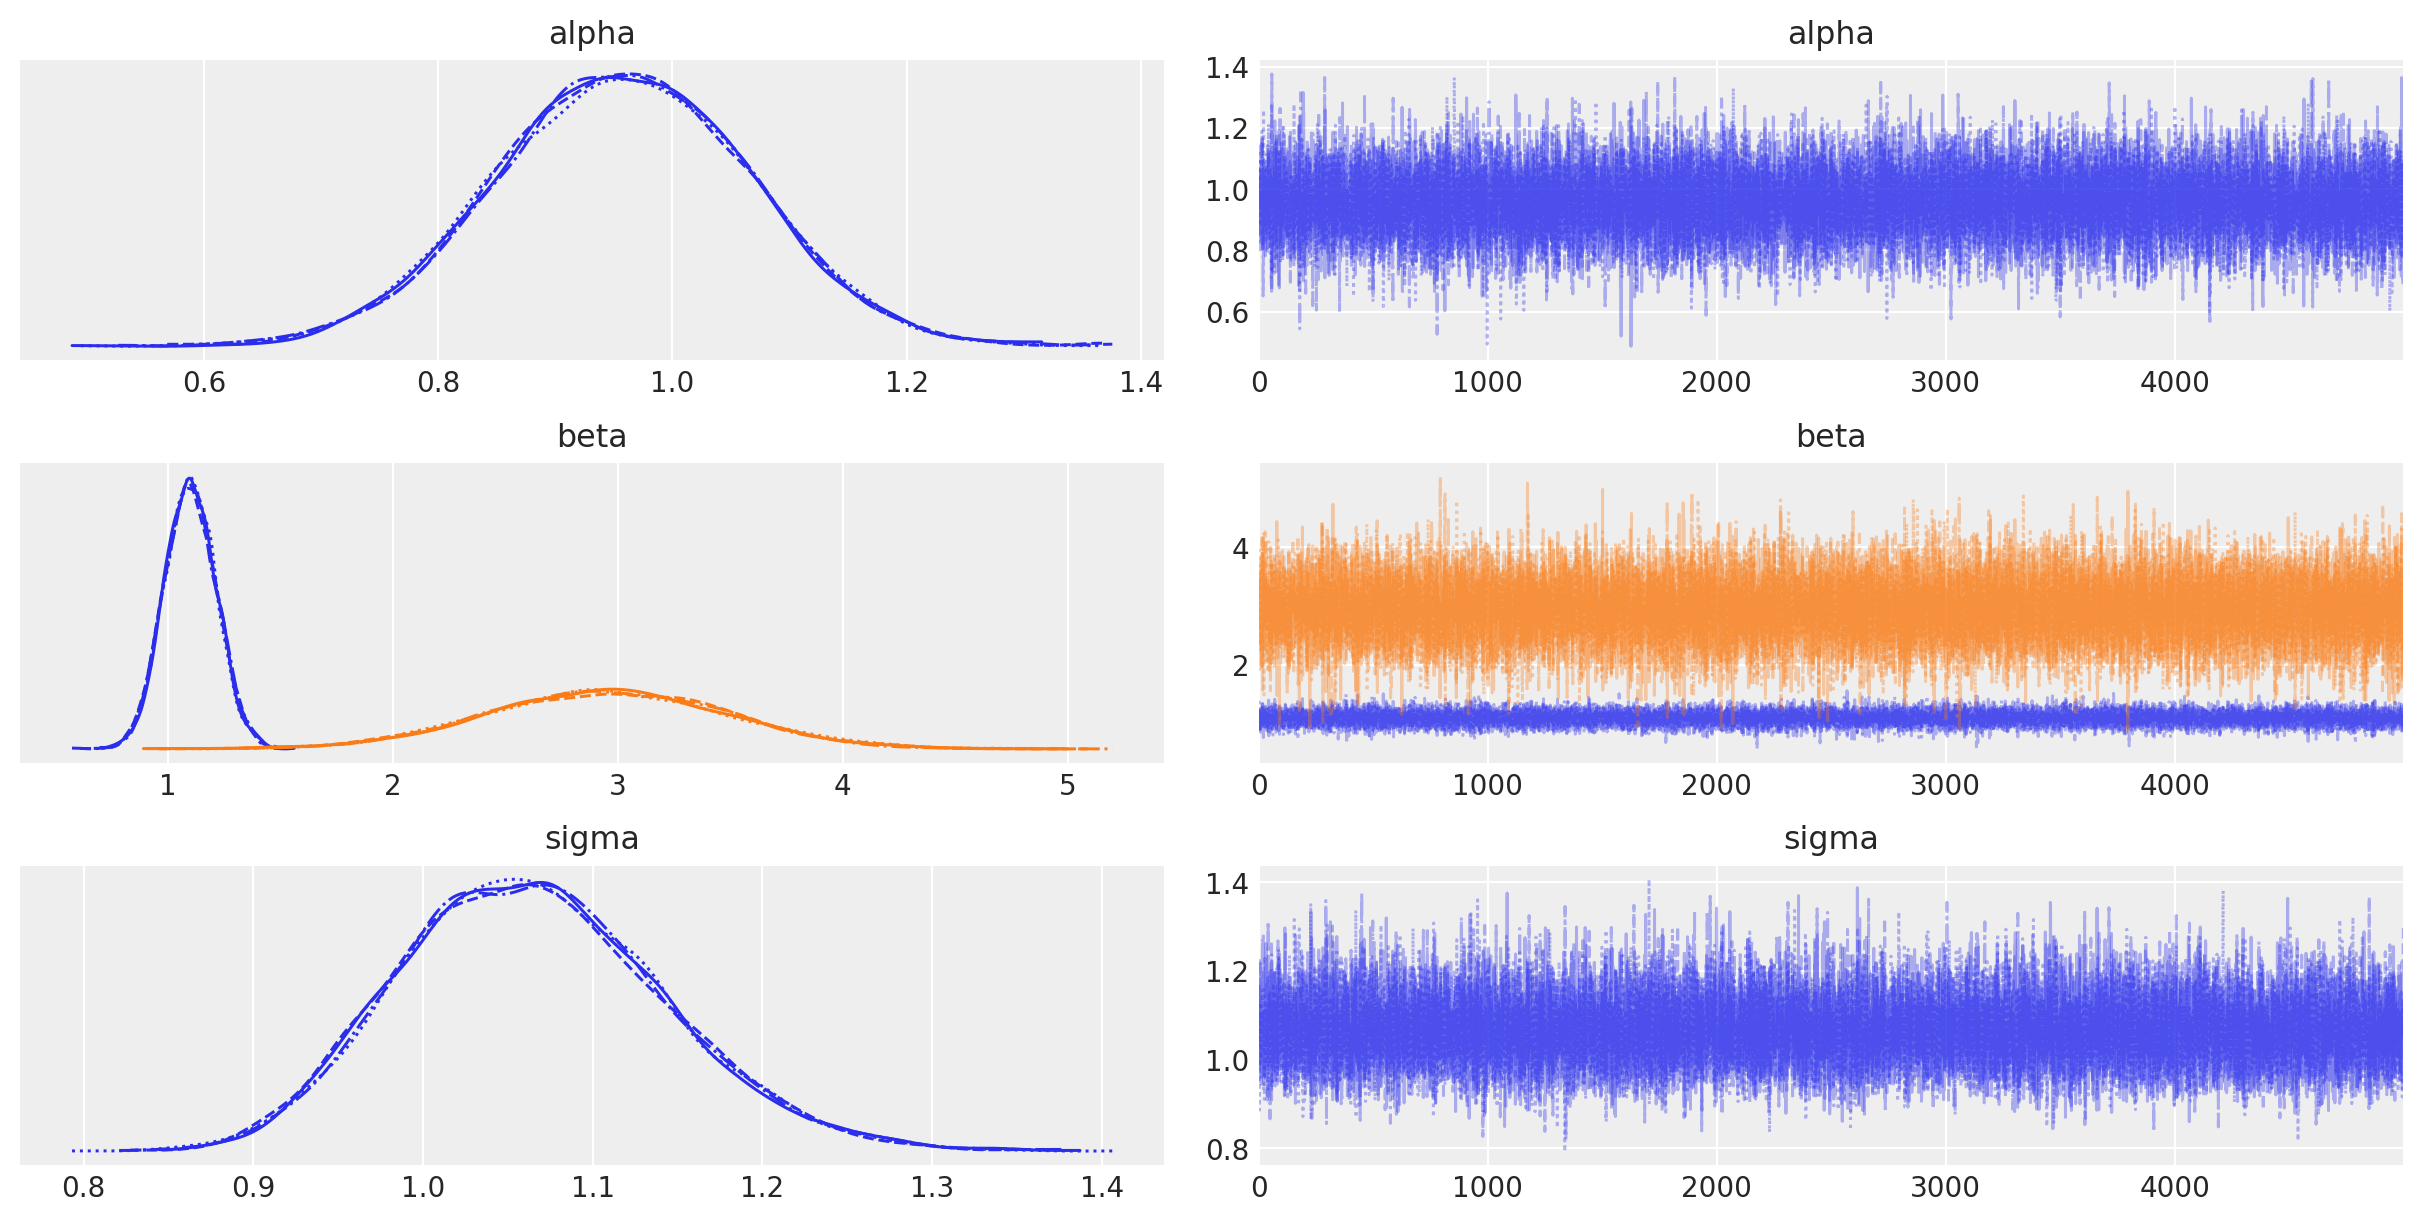

In [56]:
with basic_model:
    az.plot_trace(trace);

